In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Class representing a 2D Ising model
class Ising:
    def __init__(self, N, J, H):
        self.lattice = np.random.choice([-1,1], size=(N,N)) # initial state
        self.N = N # dimension
        self.J = np.abs(J) # interaction energy, non-negative by definition
        self.H = H # external field

In [3]:
# Function to calculate energy change when spin(i,j) is flipped, assuming periodic boundary conditions
def energy_change_of_flip(state, pos_i, pos_j):
    return 2*state.lattice[pos_i,pos_j]*(state.J*(state.lattice[pos_i,(pos_j+1)%state.N] + state.lattice[(pos_i-1)%state.N,pos_j] + state.lattice[(pos_i+1)%state.N,pos_j] + state.lattice[pos_i,(pos_j-1)%state.N])+state.H)

In [4]:
# Monte Carlo sweep using Metropolis algorithm
def monte_carlo_sweep(state, temperature):
    for i in range(len(state.lattice)**2):
        # pick a spin randomly and calculate energy change if it's flipped
        pos_i = np.random.randint(0,len(state.lattice))
        pos_j = np.random.randint(0,len(state.lattice))
        delta_E = energy_change_of_flip(state,pos_i,pos_j)
        
        # to flip or not to flip?
        if delta_E < 0 or np.exp(-delta_E/temperature) > np.random.random():
            state.lattice[pos_i,pos_j] *= -1

In [5]:
# Function to calculate magnetisation
def calculate_magnetisation(state):
    return np.sum(state.lattice)

In [6]:
# Function to calculate energy
def calculate_energy(state):
    interaction_energy = 0.0
    for pos_i in range(len(state.lattice)):
        for pos_j in range(len(state.lattice)):
            interaction_energy += -state.J*state.lattice[pos_i,pos_j]*(state.lattice[pos_i,(pos_j+1)%state.N] + state.lattice[(pos_i-1)%state.N,pos_j] + state.lattice[(pos_i+1)%state.N,pos_j] + state.lattice[pos_i,(pos_j-1)%state.N])
    interaction_energy *= 0.5 # avoid double counting
    
    magnetisation_energy = -state.H*calculate_magnetisation(state)
    
    return interaction_energy+magnetisation_energy

In [7]:
# Function to normalize data by number of lattice sites
def normalize_data(data, N):
    return data/(N**2)

In [8]:
# Metropolis algorithm
def Metropolis_algorithm(N_range, J, H, T_range, no_of_sweeps):
    # arrays to store magnetisation and energy time series
    M = np.zeros((len(N_range),len(T_range),no_of_sweeps))
    E = np.zeros((len(N_range),len(T_range),no_of_sweeps))
    M_normalized = np.zeros((len(N_range),len(T_range),no_of_sweeps))
    E_normalized = np.zeros((len(N_range),len(T_range),no_of_sweeps))
    
    # Monte Carlo sweeps
    for N_index in range(len(N_range)):
        for T_index in range(len(T_range)):
            state = Ising(N_range[N_index],J,H)
            for sweep in range(no_of_sweeps): # run!
                monte_carlo_sweep(state,T_range[T_index])
                
                M[N_index,T_index,sweep] = calculate_magnetisation(state)
                E[N_index,T_index,sweep] = calculate_energy(state)
                M_normalized[N_index,T_index,sweep] = normalize_data(M[N_index,T_index,sweep],state.N)
                E_normalized[N_index,T_index,sweep] = normalize_data(E[N_index,T_index,sweep],state.N)
                
                if sweep%500 == 0: # output checkpoints
                    print('N = {0}, T = {1}, sweep = {2}'.format(N_range[N_index],T_range[T_index],sweep))
    
    return M, E, M_normalized, E_normalized

In [173]:
# Function to plot evolution of data over time
def plot_time_series(data, N_range, N_index_range, T_range, T_index_range, start_point, stop_point, xname, yname):
    for N_index in N_index_range:
        for T_index in T_index_range:
            plt.plot(range(start_point,stop_point),data[N_index,T_index,start_point:stop_point],label='N = {0}, T = {1:.3f}'.format(N_range[N_index],T_range[T_index]))
        plt.legend(loc='upper right')
        plt.xlabel(xname)
        plt.ylabel(yname)
        plt.savefig('plots/{0} vs {1} N = {2} from {3} to {4}.png'.format(yname,xname,N_range[N_index],start_point,stop_point))
        plt.figure()

In [10]:
# Function to calculate the average of a thermodynamic variable
def calculate_thermodynamic_variable(data, N_range, T_range, no_of_equilibrating_sweeps):
    var = np.zeros((len(N_range),len(T_range)))
    
    for N_index in range(len(N_range)):
        for T_index in range(len(T_range)):
            var[N_index,T_index] = np.sum(data[N_index,T_index,no_of_equilibrating_sweeps:])/len(data[N_index,T_index,no_of_equilibrating_sweeps:])
        var[N_index,:] = normalize_data(var[N_index,:],N_range[N_index])
    
    return var

In [11]:
# Function to calculate the average of a derivative thermodynamic variable
def calculate_derivative_thermodynamic_average(data, N_range, T_range, power_of_T, no_of_equilibrating_sweeps):
    var = np.zeros((len(N_range),len(T_range)))
    
    for N_index in range(len(N_range)):
        for T_index in range(len(T_range)):
            ave = np.sum(data[N_index,T_index,no_of_equilibrating_sweeps:])/len(data[N_index,T_index,no_of_equilibrating_sweeps:])
            squared_ave = np.sum(data[N_index,T_index,no_of_equilibrating_sweeps:]**2)/len(data[N_index,T_index,no_of_equilibrating_sweeps:])
            var[N_index,T_index] = (squared_ave-ave**2)/(T_range[T_index]**power_of_T)
        var[N_index,:] = normalize_data(var[N_index,:],N_range[N_index])
    
    return var

In [12]:
# Function to plot thermodynamic variable against temperature
def plot_temperature_dependence(data, N_range, N_index_range, T_range, T_index_range, xname, yname):
    for N_index in N_index_range:
        plt.plot(T_range[T_index_range[0]:(T_index_range[-1]+1)],data[N_index,T_index_range[0]:(T_index_range[-1]+1)],'-o',label='N = {0}'.format(N_range[N_index]))
        # +1 to include last element
    plt.legend(loc='upper right')
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.savefig('plots/{0} vs {1} from {2:.3f} to {3:.3f}.png'.format(yname,xname,T_range[T_index_range[0]],T_range[T_index_range[-1]]))
    plt.figure()

In [168]:
# Function to calculate the autocorrelation of a variable
def calculate_autocovariation(data, N_range, T_range, no_of_sweeps, no_of_equilibrating_sweeps):
    no_of_sampling_sweeps = no_of_sweeps-no_of_equilibrating_sweeps
    autocovariation = np.zeros((len(N_range),len(T_range),no_of_sampling_sweeps))
    
    for N_index in range(len(N_range)):
        for T_index in range(len(T_range)):
            ave = np.sum(data[N_index,T_index,:])/no_of_sampling_sweeps
            for tau in range(no_of_sampling_sweeps):
                autocorr = 0.0
                for i in range(no_of_equilibrating_sweeps,no_of_sweeps-tau):
                    autocorr += (data[N_index,T_index,i]-ave)*(data[N_index,T_index,i+tau]-ave)
                autocovariation[N_index,T_index,tau] = autocorr
            if autocovariation[N_index,T_index,0] == 0:
                autocovariation[N_index,T_index,:] = np.ones(no_of_sampling_sweeps)
            else:
                autocovariation[N_index,T_index,:] = autocovariation[N_index,T_index,:]/autocovariation[N_index,T_index,0]
    
    return autocovariation

In [14]:
# Set parameters and run the experiment!
Ns = [4, 6, 10, 14]
J = 1.0
H = 0.0
Ts = np.linspace(0.5,4.1,60) # T=2.269 will be at Ts[29]
sweeps = 4000
equilibrating_sweeps = 3000

magnetisation, energy, magnetisation_per_site, energy_per_site = Metropolis_algorithm(Ns,J,H,Ts,sweeps)

N = 4, T = 0.5, sweep = 0
N = 4, T = 0.5, sweep = 500
N = 4, T = 0.5, sweep = 1000
N = 4, T = 0.5, sweep = 1500
N = 4, T = 0.5, sweep = 2000
N = 4, T = 0.5, sweep = 2500
N = 4, T = 0.5, sweep = 3000
N = 4, T = 0.5, sweep = 3500
N = 4, T = 0.5610169491525424, sweep = 0
N = 4, T = 0.5610169491525424, sweep = 500
N = 4, T = 0.5610169491525424, sweep = 1000
N = 4, T = 0.5610169491525424, sweep = 1500
N = 4, T = 0.5610169491525424, sweep = 2000
N = 4, T = 0.5610169491525424, sweep = 2500
N = 4, T = 0.5610169491525424, sweep = 3000
N = 4, T = 0.5610169491525424, sweep = 3500
N = 4, T = 0.6220338983050847, sweep = 0
N = 4, T = 0.6220338983050847, sweep = 500
N = 4, T = 0.6220338983050847, sweep = 1000
N = 4, T = 0.6220338983050847, sweep = 1500
N = 4, T = 0.6220338983050847, sweep = 2000
N = 4, T = 0.6220338983050847, sweep = 2500
N = 4, T = 0.6220338983050847, sweep = 3000
N = 4, T = 0.6220338983050847, sweep = 3500
N = 4, T = 0.6830508474576271, sweep = 0
N = 4, T = 0.6830508474576271, swee

N = 4, T = 1.964406779661017, sweep = 0
N = 4, T = 1.964406779661017, sweep = 500
N = 4, T = 1.964406779661017, sweep = 1000
N = 4, T = 1.964406779661017, sweep = 1500
N = 4, T = 1.964406779661017, sweep = 2000
N = 4, T = 1.964406779661017, sweep = 2500
N = 4, T = 1.964406779661017, sweep = 3000
N = 4, T = 1.964406779661017, sweep = 3500
N = 4, T = 2.0254237288135593, sweep = 0
N = 4, T = 2.0254237288135593, sweep = 500
N = 4, T = 2.0254237288135593, sweep = 1000
N = 4, T = 2.0254237288135593, sweep = 1500
N = 4, T = 2.0254237288135593, sweep = 2000
N = 4, T = 2.0254237288135593, sweep = 2500
N = 4, T = 2.0254237288135593, sweep = 3000
N = 4, T = 2.0254237288135593, sweep = 3500
N = 4, T = 2.0864406779661016, sweep = 0
N = 4, T = 2.0864406779661016, sweep = 500
N = 4, T = 2.0864406779661016, sweep = 1000
N = 4, T = 2.0864406779661016, sweep = 1500
N = 4, T = 2.0864406779661016, sweep = 2000
N = 4, T = 2.0864406779661016, sweep = 2500
N = 4, T = 2.0864406779661016, sweep = 3000
N = 4, T

N = 4, T = 3.367796610169491, sweep = 3500
N = 4, T = 3.428813559322034, sweep = 0
N = 4, T = 3.428813559322034, sweep = 500
N = 4, T = 3.428813559322034, sweep = 1000
N = 4, T = 3.428813559322034, sweep = 1500
N = 4, T = 3.428813559322034, sweep = 2000
N = 4, T = 3.428813559322034, sweep = 2500
N = 4, T = 3.428813559322034, sweep = 3000
N = 4, T = 3.428813559322034, sweep = 3500
N = 4, T = 3.489830508474576, sweep = 0
N = 4, T = 3.489830508474576, sweep = 500
N = 4, T = 3.489830508474576, sweep = 1000
N = 4, T = 3.489830508474576, sweep = 1500
N = 4, T = 3.489830508474576, sweep = 2000
N = 4, T = 3.489830508474576, sweep = 2500
N = 4, T = 3.489830508474576, sweep = 3000
N = 4, T = 3.489830508474576, sweep = 3500
N = 4, T = 3.5508474576271185, sweep = 0
N = 4, T = 3.5508474576271185, sweep = 500
N = 4, T = 3.5508474576271185, sweep = 1000
N = 4, T = 3.5508474576271185, sweep = 1500
N = 4, T = 3.5508474576271185, sweep = 2000
N = 4, T = 3.5508474576271185, sweep = 2500
N = 4, T = 3.5508

N = 6, T = 1.2322033898305085, sweep = 1500
N = 6, T = 1.2322033898305085, sweep = 2000
N = 6, T = 1.2322033898305085, sweep = 2500
N = 6, T = 1.2322033898305085, sweep = 3000
N = 6, T = 1.2322033898305085, sweep = 3500
N = 6, T = 1.2932203389830508, sweep = 0
N = 6, T = 1.2932203389830508, sweep = 500
N = 6, T = 1.2932203389830508, sweep = 1000
N = 6, T = 1.2932203389830508, sweep = 1500
N = 6, T = 1.2932203389830508, sweep = 2000
N = 6, T = 1.2932203389830508, sweep = 2500
N = 6, T = 1.2932203389830508, sweep = 3000
N = 6, T = 1.2932203389830508, sweep = 3500
N = 6, T = 1.354237288135593, sweep = 0
N = 6, T = 1.354237288135593, sweep = 500
N = 6, T = 1.354237288135593, sweep = 1000
N = 6, T = 1.354237288135593, sweep = 1500
N = 6, T = 1.354237288135593, sweep = 2000
N = 6, T = 1.354237288135593, sweep = 2500
N = 6, T = 1.354237288135593, sweep = 3000
N = 6, T = 1.354237288135593, sweep = 3500
N = 6, T = 1.4152542372881354, sweep = 0
N = 6, T = 1.4152542372881354, sweep = 500
N = 6, T

N = 6, T = 2.6966101694915254, sweep = 500
N = 6, T = 2.6966101694915254, sweep = 1000
N = 6, T = 2.6966101694915254, sweep = 1500
N = 6, T = 2.6966101694915254, sweep = 2000
N = 6, T = 2.6966101694915254, sweep = 2500
N = 6, T = 2.6966101694915254, sweep = 3000
N = 6, T = 2.6966101694915254, sweep = 3500
N = 6, T = 2.7576271186440677, sweep = 0
N = 6, T = 2.7576271186440677, sweep = 500
N = 6, T = 2.7576271186440677, sweep = 1000
N = 6, T = 2.7576271186440677, sweep = 1500
N = 6, T = 2.7576271186440677, sweep = 2000
N = 6, T = 2.7576271186440677, sweep = 2500
N = 6, T = 2.7576271186440677, sweep = 3000
N = 6, T = 2.7576271186440677, sweep = 3500
N = 6, T = 2.81864406779661, sweep = 0
N = 6, T = 2.81864406779661, sweep = 500
N = 6, T = 2.81864406779661, sweep = 1000
N = 6, T = 2.81864406779661, sweep = 1500
N = 6, T = 2.81864406779661, sweep = 2000
N = 6, T = 2.81864406779661, sweep = 2500
N = 6, T = 2.81864406779661, sweep = 3000
N = 6, T = 2.81864406779661, sweep = 3500
N = 6, T = 2.

N = 10, T = 0.5, sweep = 2000
N = 10, T = 0.5, sweep = 2500
N = 10, T = 0.5, sweep = 3000
N = 10, T = 0.5, sweep = 3500
N = 10, T = 0.5610169491525424, sweep = 0
N = 10, T = 0.5610169491525424, sweep = 500
N = 10, T = 0.5610169491525424, sweep = 1000
N = 10, T = 0.5610169491525424, sweep = 1500
N = 10, T = 0.5610169491525424, sweep = 2000
N = 10, T = 0.5610169491525424, sweep = 2500
N = 10, T = 0.5610169491525424, sweep = 3000
N = 10, T = 0.5610169491525424, sweep = 3500
N = 10, T = 0.6220338983050847, sweep = 0
N = 10, T = 0.6220338983050847, sweep = 500
N = 10, T = 0.6220338983050847, sweep = 1000
N = 10, T = 0.6220338983050847, sweep = 1500
N = 10, T = 0.6220338983050847, sweep = 2000
N = 10, T = 0.6220338983050847, sweep = 2500
N = 10, T = 0.6220338983050847, sweep = 3000
N = 10, T = 0.6220338983050847, sweep = 3500
N = 10, T = 0.6830508474576271, sweep = 0
N = 10, T = 0.6830508474576271, sweep = 500
N = 10, T = 0.6830508474576271, sweep = 1000
N = 10, T = 0.6830508474576271, sweep

N = 10, T = 1.9033898305084744, sweep = 3500
N = 10, T = 1.964406779661017, sweep = 0
N = 10, T = 1.964406779661017, sweep = 500
N = 10, T = 1.964406779661017, sweep = 1000
N = 10, T = 1.964406779661017, sweep = 1500
N = 10, T = 1.964406779661017, sweep = 2000
N = 10, T = 1.964406779661017, sweep = 2500
N = 10, T = 1.964406779661017, sweep = 3000
N = 10, T = 1.964406779661017, sweep = 3500
N = 10, T = 2.0254237288135593, sweep = 0
N = 10, T = 2.0254237288135593, sweep = 500
N = 10, T = 2.0254237288135593, sweep = 1000
N = 10, T = 2.0254237288135593, sweep = 1500
N = 10, T = 2.0254237288135593, sweep = 2000
N = 10, T = 2.0254237288135593, sweep = 2500
N = 10, T = 2.0254237288135593, sweep = 3000
N = 10, T = 2.0254237288135593, sweep = 3500
N = 10, T = 2.0864406779661016, sweep = 0
N = 10, T = 2.0864406779661016, sweep = 500
N = 10, T = 2.0864406779661016, sweep = 1000
N = 10, T = 2.0864406779661016, sweep = 1500
N = 10, T = 2.0864406779661016, sweep = 2000
N = 10, T = 2.0864406779661016

N = 10, T = 3.367796610169491, sweep = 1000
N = 10, T = 3.367796610169491, sweep = 1500
N = 10, T = 3.367796610169491, sweep = 2000
N = 10, T = 3.367796610169491, sweep = 2500
N = 10, T = 3.367796610169491, sweep = 3000
N = 10, T = 3.367796610169491, sweep = 3500
N = 10, T = 3.428813559322034, sweep = 0
N = 10, T = 3.428813559322034, sweep = 500
N = 10, T = 3.428813559322034, sweep = 1000
N = 10, T = 3.428813559322034, sweep = 1500
N = 10, T = 3.428813559322034, sweep = 2000
N = 10, T = 3.428813559322034, sweep = 2500
N = 10, T = 3.428813559322034, sweep = 3000
N = 10, T = 3.428813559322034, sweep = 3500
N = 10, T = 3.489830508474576, sweep = 0
N = 10, T = 3.489830508474576, sweep = 500
N = 10, T = 3.489830508474576, sweep = 1000
N = 10, T = 3.489830508474576, sweep = 1500
N = 10, T = 3.489830508474576, sweep = 2000
N = 10, T = 3.489830508474576, sweep = 2500
N = 10, T = 3.489830508474576, sweep = 3000
N = 10, T = 3.489830508474576, sweep = 3500
N = 10, T = 3.5508474576271185, sweep = 

N = 14, T = 1.1711864406779662, sweep = 500
N = 14, T = 1.1711864406779662, sweep = 1000
N = 14, T = 1.1711864406779662, sweep = 1500
N = 14, T = 1.1711864406779662, sweep = 2000
N = 14, T = 1.1711864406779662, sweep = 2500
N = 14, T = 1.1711864406779662, sweep = 3000
N = 14, T = 1.1711864406779662, sweep = 3500
N = 14, T = 1.2322033898305085, sweep = 0
N = 14, T = 1.2322033898305085, sweep = 500
N = 14, T = 1.2322033898305085, sweep = 1000
N = 14, T = 1.2322033898305085, sweep = 1500
N = 14, T = 1.2322033898305085, sweep = 2000
N = 14, T = 1.2322033898305085, sweep = 2500
N = 14, T = 1.2322033898305085, sweep = 3000
N = 14, T = 1.2322033898305085, sweep = 3500
N = 14, T = 1.2932203389830508, sweep = 0
N = 14, T = 1.2932203389830508, sweep = 500
N = 14, T = 1.2932203389830508, sweep = 1000
N = 14, T = 1.2932203389830508, sweep = 1500
N = 14, T = 1.2932203389830508, sweep = 2000
N = 14, T = 1.2932203389830508, sweep = 2500
N = 14, T = 1.2932203389830508, sweep = 3000
N = 14, T = 1.29322

N = 14, T = 2.5745762711864404, sweep = 1500
N = 14, T = 2.5745762711864404, sweep = 2000
N = 14, T = 2.5745762711864404, sweep = 2500
N = 14, T = 2.5745762711864404, sweep = 3000
N = 14, T = 2.5745762711864404, sweep = 3500
N = 14, T = 2.6355932203389827, sweep = 0
N = 14, T = 2.6355932203389827, sweep = 500
N = 14, T = 2.6355932203389827, sweep = 1000
N = 14, T = 2.6355932203389827, sweep = 1500
N = 14, T = 2.6355932203389827, sweep = 2000
N = 14, T = 2.6355932203389827, sweep = 2500
N = 14, T = 2.6355932203389827, sweep = 3000
N = 14, T = 2.6355932203389827, sweep = 3500
N = 14, T = 2.6966101694915254, sweep = 0
N = 14, T = 2.6966101694915254, sweep = 500
N = 14, T = 2.6966101694915254, sweep = 1000
N = 14, T = 2.6966101694915254, sweep = 1500
N = 14, T = 2.6966101694915254, sweep = 2000
N = 14, T = 2.6966101694915254, sweep = 2500
N = 14, T = 2.6966101694915254, sweep = 3000
N = 14, T = 2.6966101694915254, sweep = 3500
N = 14, T = 2.7576271186440677, sweep = 0
N = 14, T = 2.7576271

N = 14, T = 3.977966101694915, sweep = 2500
N = 14, T = 3.977966101694915, sweep = 3000
N = 14, T = 3.977966101694915, sweep = 3500
N = 14, T = 4.038983050847458, sweep = 0
N = 14, T = 4.038983050847458, sweep = 500
N = 14, T = 4.038983050847458, sweep = 1000
N = 14, T = 4.038983050847458, sweep = 1500
N = 14, T = 4.038983050847458, sweep = 2000
N = 14, T = 4.038983050847458, sweep = 2500
N = 14, T = 4.038983050847458, sweep = 3000
N = 14, T = 4.038983050847458, sweep = 3500
N = 14, T = 4.1, sweep = 0
N = 14, T = 4.1, sweep = 500
N = 14, T = 4.1, sweep = 1000
N = 14, T = 4.1, sweep = 1500
N = 14, T = 4.1, sweep = 2000
N = 14, T = 4.1, sweep = 2500
N = 14, T = 4.1, sweep = 3000
N = 14, T = 4.1, sweep = 3500


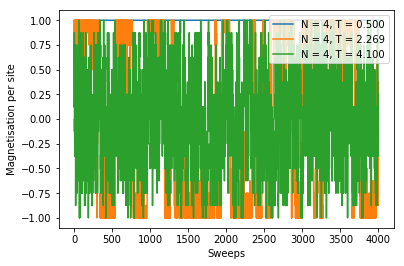

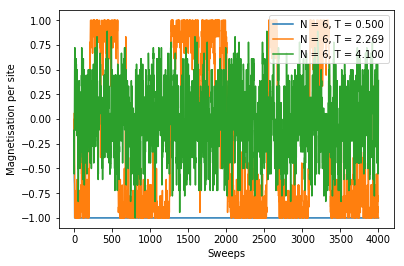

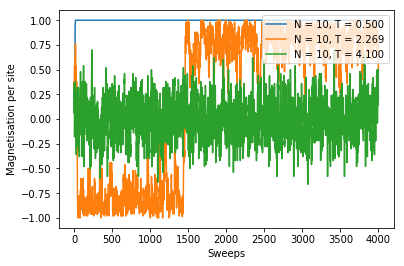

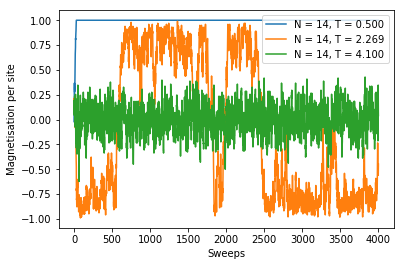

In [125]:
# Plot time evolution
N_indices = range(len(Ns))
T_indices = [0,29,59]
startpt = 0
stoppt = sweeps
plot_time_series(magnetisation_per_site,Ns,N_indices,Ts,T_indices,startpt,stoppt,'Sweeps','Magnetisation per site')

In [169]:
# How total magnetisation fluctuates with time when system is in equilibrium
magnetisation_autocovariance = calculate_autocovariation(magnetisation,Ns,Ts,sweeps,equilibrating_sweeps)

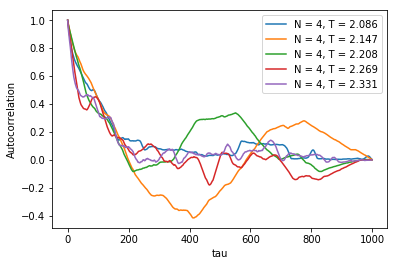

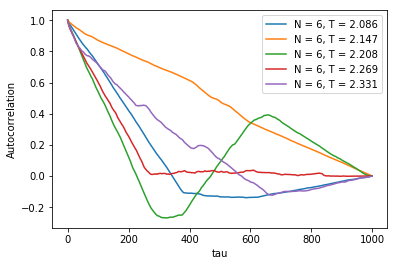

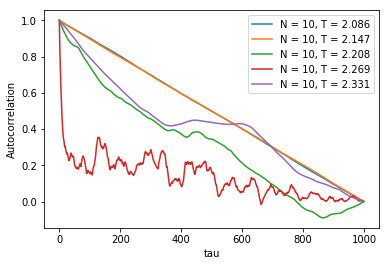

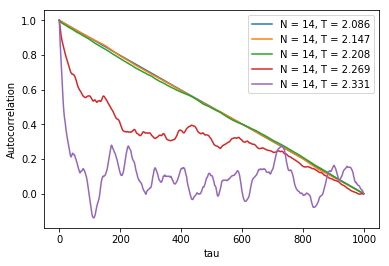

In [181]:
# Plot autocovariance of total magnetisation
N_indices = range(len(Ns))
T_indices = range(26,31)
startpt = 0
stoppt = 1000
plot_time_series(magnetisation_autocovariance,Ns,N_indices,Ts,T_indices,startpt,stoppt,'tau','Autocorrelation')

In [177]:
# Calculate thermodynamic variables
average_magnetisation = calculate_thermodynamic_variable(np.abs(magnetisation),Ns,Ts,equilibrating_sweeps)
average_energy = calculate_thermodynamic_variable(energy,Ns,Ts,equilibrating_sweeps)
average_susceptibility = calculate_derivative_thermodynamic_average(np.abs(magnetisation),Ns,Ts,1,equilibrating_sweeps)
average_heat_capacity = calculate_derivative_thermodynamic_average(energy,Ns,Ts,2,equilibrating_sweeps)

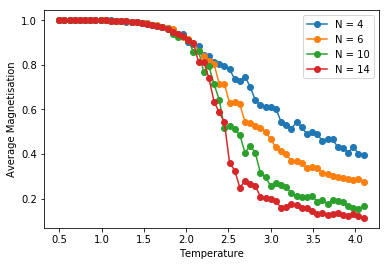

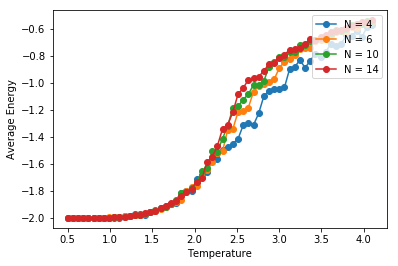

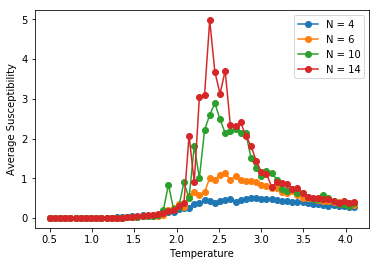

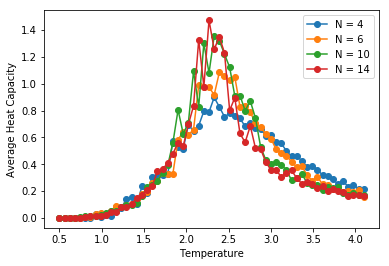

In [178]:
# Plot thermodynamic variables
N_indices = range(len(Ns))
T_indices = range(len(Ts))
plot_temperature_dependence(average_magnetisation,Ns,N_indices,Ts,T_indices,'Temperature','Average Magnetisation')
plot_temperature_dependence(average_energy,Ns,N_indices,Ts,T_indices,'Temperature','Average Energy')
plot_temperature_dependence(average_susceptibility,Ns,N_indices,Ts,T_indices,'Temperature','Average Susceptibility')
plot_temperature_dependence(average_heat_capacity,Ns,N_indices,Ts,T_indices,'Temperature','Average Heat Capacity')